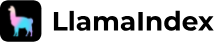

https://www.llamaindex.ai/

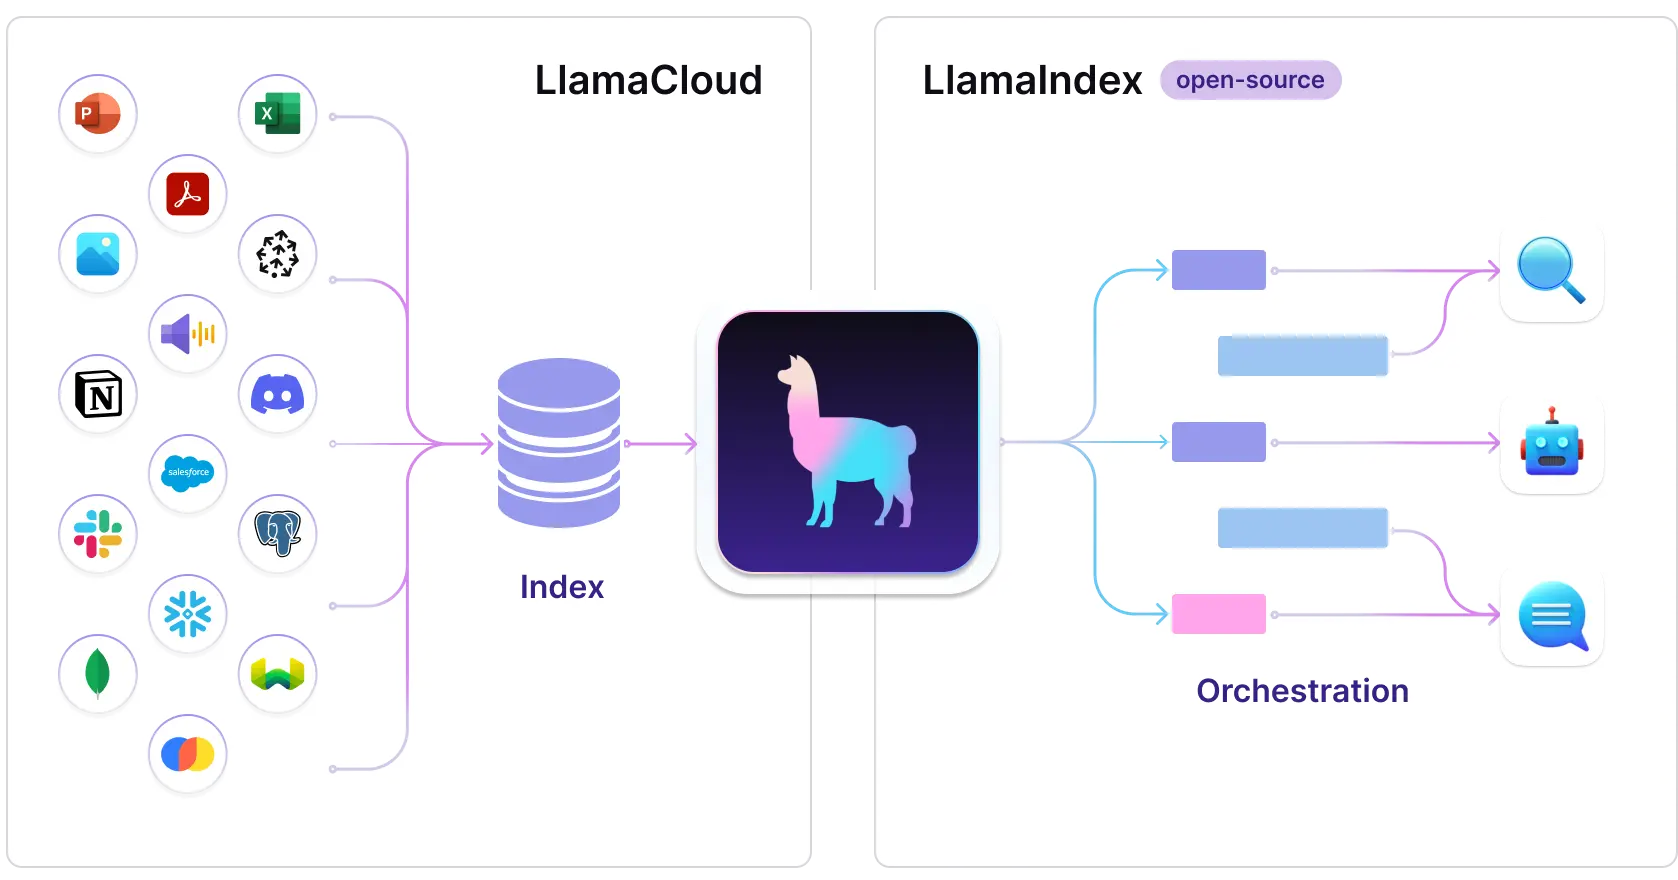

https://www.eum.go.kr/web/in/pd/pdBoardList.jsp?subType=C

In [ ]:
!pip install llama-index
!pip install langchain_community

In [ ]:

import logging
import sys

from llama_index.core import VectorStoreIndex, SimpleDirectoryReader,GPTVectorStoreIndex, ServiceContext
from llama_index.core.prompts.prompts import QuestionAnswerPrompt, RefinePrompt

from langchain.chat_models import ChatOpenAI
import os

import warnings

In [ ]:

warnings.filterwarnings('ignore')

# 'openai' 로거의 로그 레벨을 WARNING으로 설정하여 디버그 메시지 비활성화
logging.getLogger('openai').setLevel(logging.WARNING)


In [ ]:
os.environ['OPENAI_API_KEY'] = 'API_KEY'
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG, force=True)

In [ ]:
!wget "https://hycms.hanyang.ac.kr/index.php?module=xn_media_content2013&act=dispXn_media_content2013DownloadContent&content_id=6742dd8a40164" -O "pdf.zip"
!unzip  -O cp949 "pdf.zip" -d "data"


In [ ]:

documents = SimpleDirectoryReader('data', exclude_hidden=True, recursive=True).load_data()
index = GPTVectorStoreIndex.from_documents(documents)

In [ ]:


query_engine = index.as_query_engine()

# Text QA templates
BV_TEXT_QA_PROMPT_TMPL = (
    "천안시의 도시군기본계획 내용을 바탕으로 답변합니다. \n"
    "아래는 답변을 위해 도시군기본계획에서 추출한 일부 내용입니다. \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "Given the context information answer the following question "
    "(if you don't know the answer, use the best of your knowledge): {query_str}\n"
    "답변은 한글로 하세요. 친절하게 답변바랍니다.\n"
    "관련 답변의 근거를 도시군기본계획의 어느 부분을 참고했는지 함께 알려줘요."
)
TEXT_QA_TEMPLATE = QuestionAnswerPrompt(BV_TEXT_QA_PROMPT_TMPL)

# Refine templates
BV_REFINE_PROMPT_TMPL = (
    "The original question is as follows: {query_str}\n"
    "We have provided an existing answer: {existing_answer}\n"
    "We have the opportunity to refine the existing answer "
    "(only if needed) with some more context below.\n"
    "------------\n"
    "{context_msg}\n"
    "------------\n"
    "Given the new context and using the best of your knowledge, improve the existing answer. "
    "If you can't improve the existing answer, just repeat it again.\n"
    "답변은 한글로 하세요. 친절하게 답변바랍니다."
    "관련 답변의 근거를 도시군기본계획의 어느 부분을 참고했는지 함께 알려줘요."
)
REFINE_TEMPLATE = RefinePrompt(BV_REFINE_PROMPT_TMPL)


In [ ]:

query_engine.get_prompts().keys()
query_engine.update_prompts({'response_synthesizer:text_qa_template': TEXT_QA_TEMPLATE})
query_engine.update_prompts({'response_synthesizer:refine_template': REFINE_TEMPLATE})

query_engine.get_prompts()



In [ ]:

user_query = '현재 김천시의 인구는 어떻게 되는지?'
answer = query_engine.query(user_query)

print(answer)


In [ ]:

user_query = '김천시의 도시군기본계획의 핵심 골자는?'
answer = query_engine.query(user_query)

print(answer)


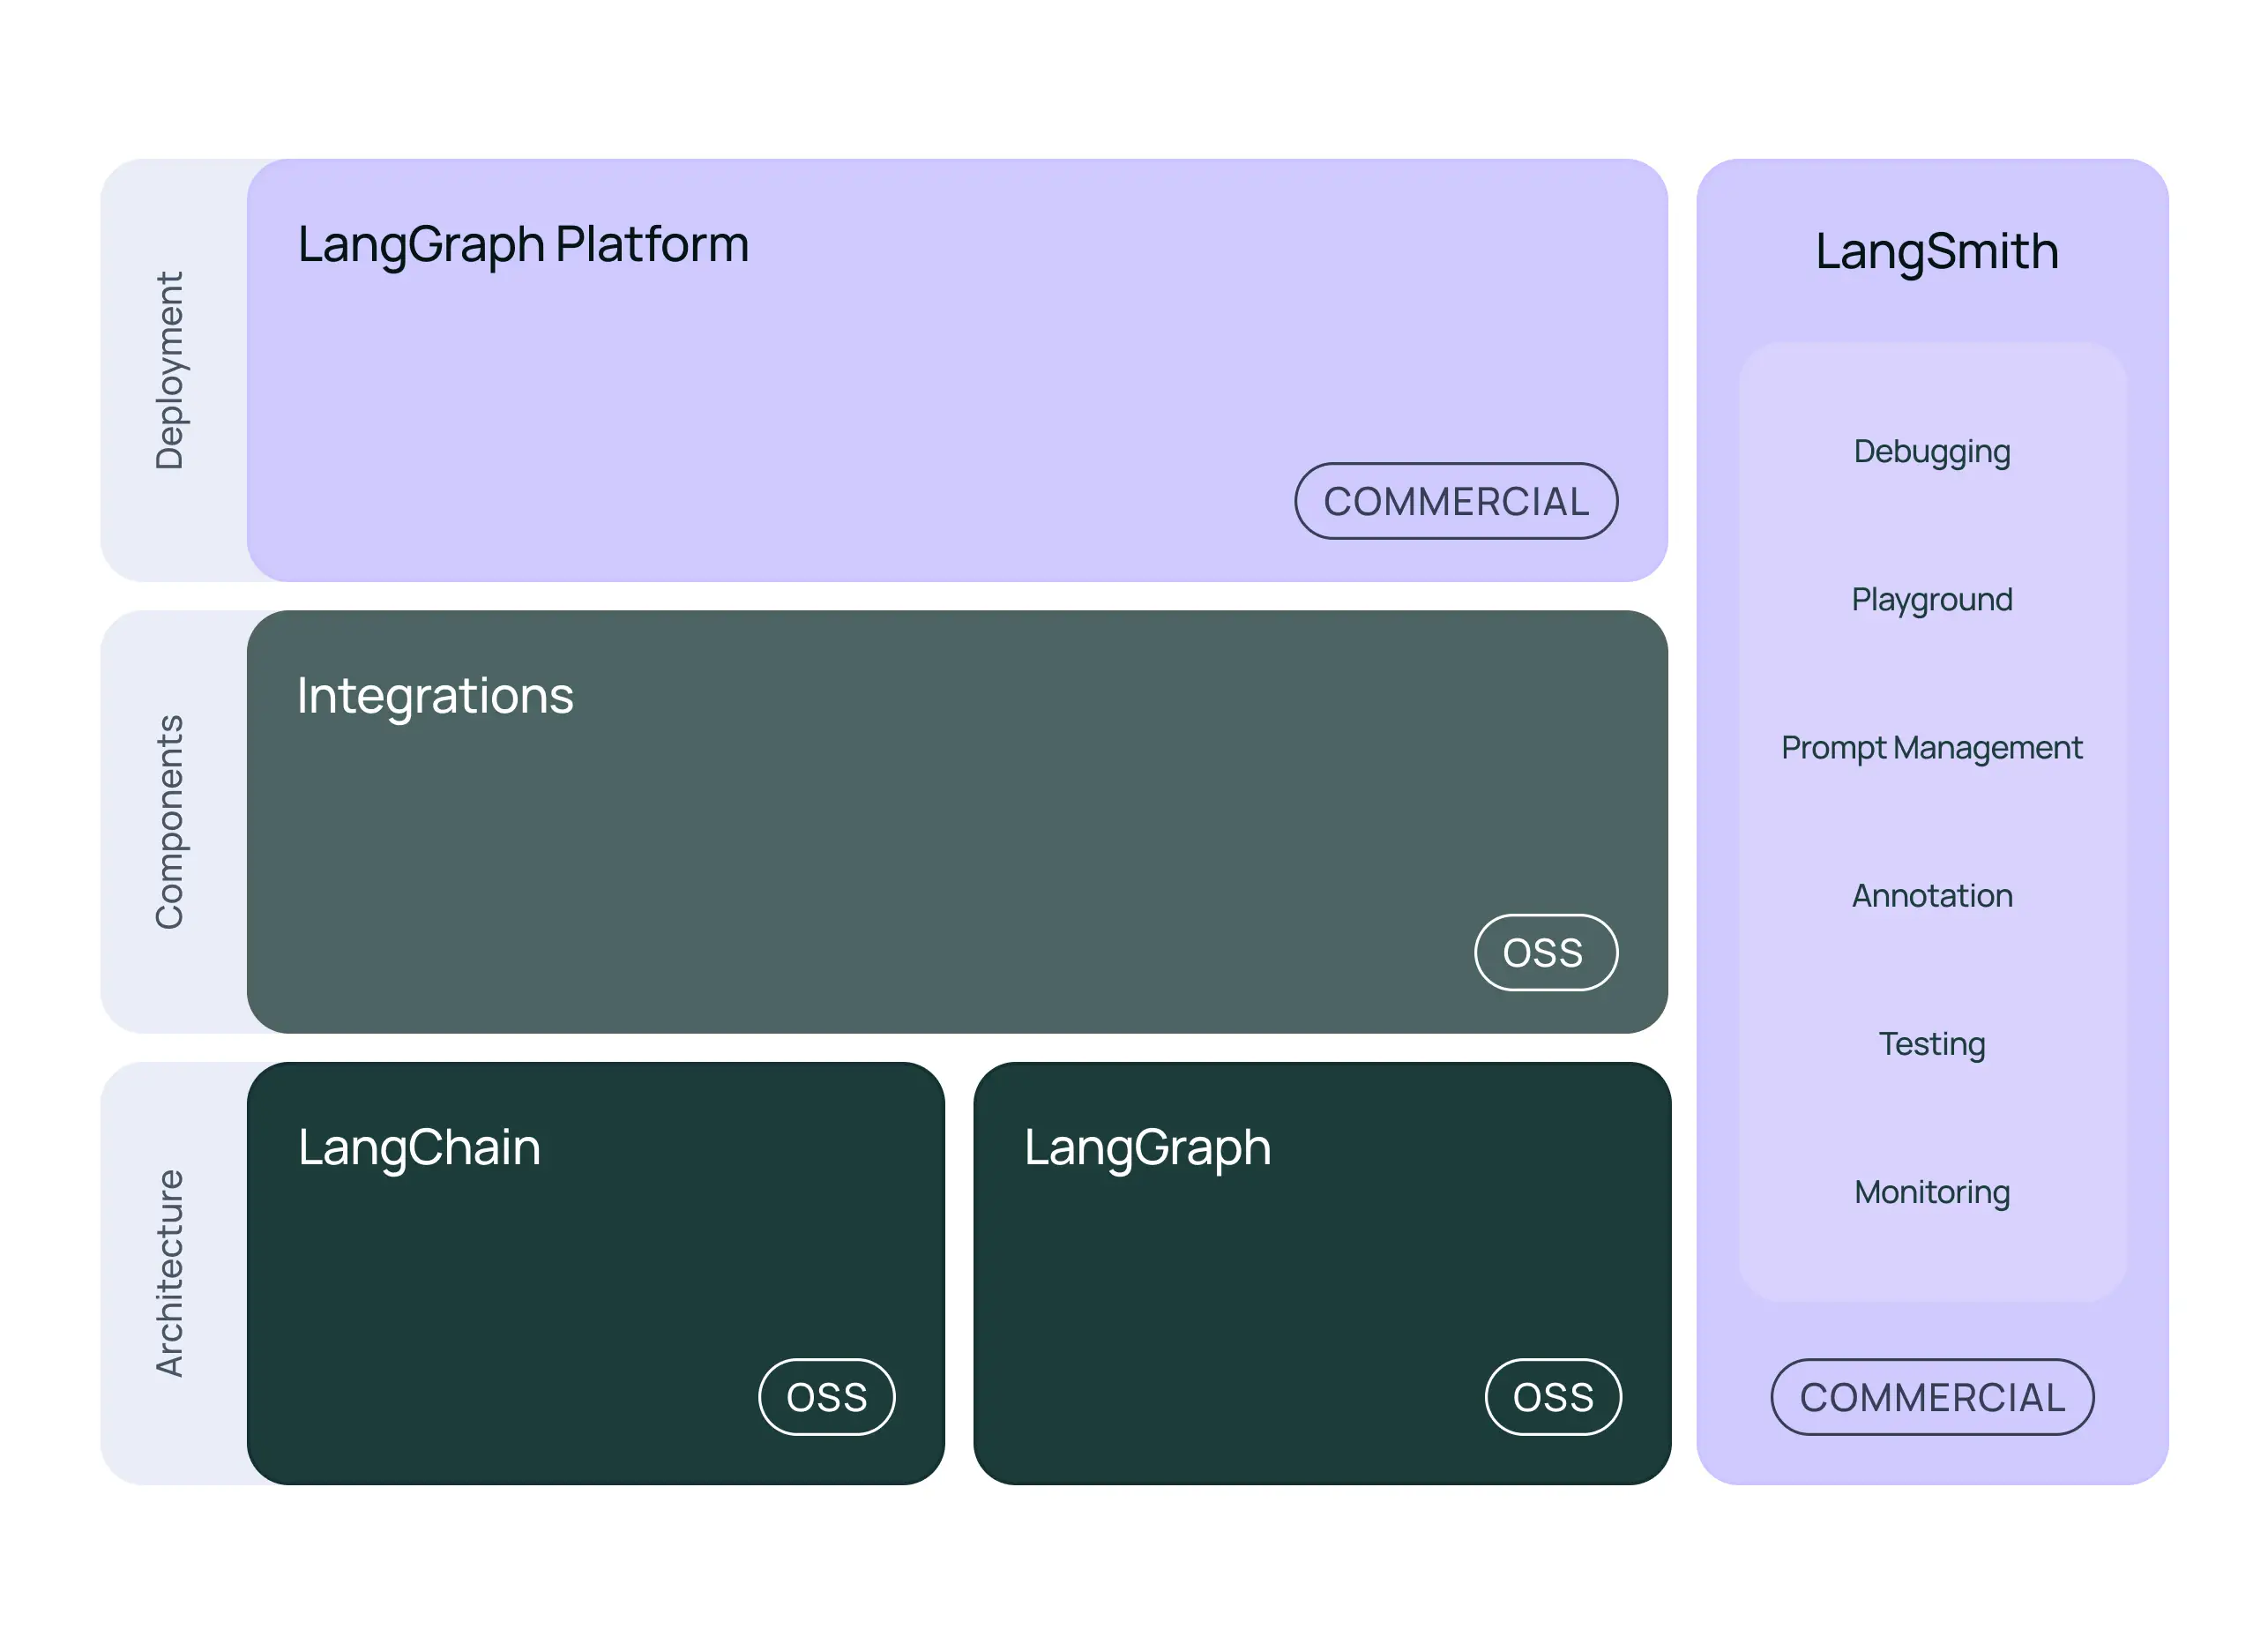

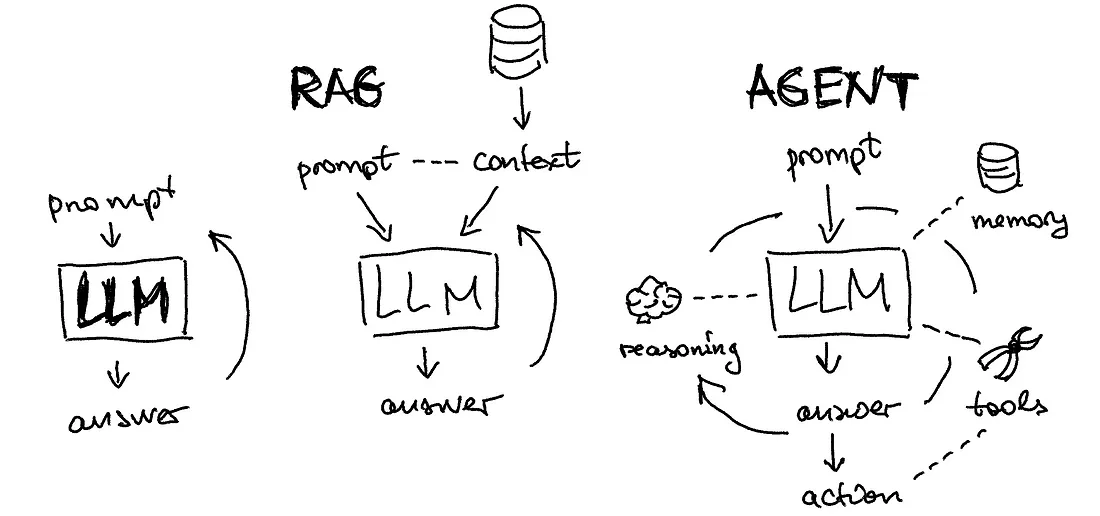

https://towardsdatascience.com/intro-to-llm-agents-with-langchain-when-rag-is-not-enough-7d8c08145834